## Pupil Gluing Characterisation 🖌️

This notebook:
1. Calculates the Zernike coefficients on two separate starphire plates
2. Calculates the Zernike coefficients on the glued starphire setup

It is helpful to the phase retrieval process that data taken for the non-glued plates and glued setup have the same orientation.

Existing system aberrations are loaded and can be calculated using System_Aberrations.ipynb

In [1]:
import dLux as dl
import dLux.utils as dlu

import jax.numpy as jnp
import numpy as np
import jax.random as jr
import jax.scipy as jsp
from jax import vmap  
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update('jax_disable_jit', False)

import zodiax as zdx
import optax
from tqdm.notebook import tqdm

from skimage.io import imread
from skimage.filters import window
import skimage as ski
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'upper' # true reading of array
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["figure.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 15

data_dir = "/import/morgana2/gpir9156/toliman/"

# Detector response (gamma curve)
alpha = np.load(data_dir+"detector/80us_detector/ALPHA_norm.npy")
beta = np.load(data_dir+"detector/80us_detector/BETA_norm.npy")
gamma = np.load(data_dir+"detector/80us_detector/GAMMA_norm.npy")

### System Parameters

In [2]:
# ------- Physical Parameters ---------------------------------------------------------------------#
aperture_npix = 512           # Number of pixels across the aperture
aperture_diameter = 122e-3    # (m) slightly smaller for mask cap
spider_width = 20e-3          # Spider width (m)
spider_angle =270             # Spider angle (degrees), clockwise, 0 is spider pointing vertically up
coords = dlu.pixel_coords(npixels=aperture_npix, diameter=aperture_diameter)
circle = dlu.circle(coords=coords, radius=aperture_diameter/2) 

# Observations wavelengths (bandpass of 530-640nm)
red_laser_wl =  635e-09  # for laser data
green_laser_wl = 520e-09  # for laser data
wf_npixels = aperture_npix  # Number of pixels across the wavefront
wf_diam = aperture_diameter             # Diameter of initial wavefront to propagate wavefront (m)

# Detector parameters (BFS-U3-200S6-BD)
BFS_px_sep = 2.4e-6 *1e3        # pixel separation (mm)
f_det = 1338 # 1300#1350                    # Focal length from OAP2 to detector (mm) 
px_ang_sep = 2*np.arctan( (BFS_px_sep/2)/f_det ) # angular sep between pixels (rad)

# Simulated Detector
psf_npix = 40                 # Number of pixels along one dim of the PSF
psf_hlf_sz = int(psf_npix/2)             # half window sz of cropped data
oversample = 1                 # Oversampling factor for the PSF
psf_pixel_scale = dlu.rad2arcsec(px_ang_sep) # arcsec (to match detector plate scale) 80e-4 


### Simulated Setup

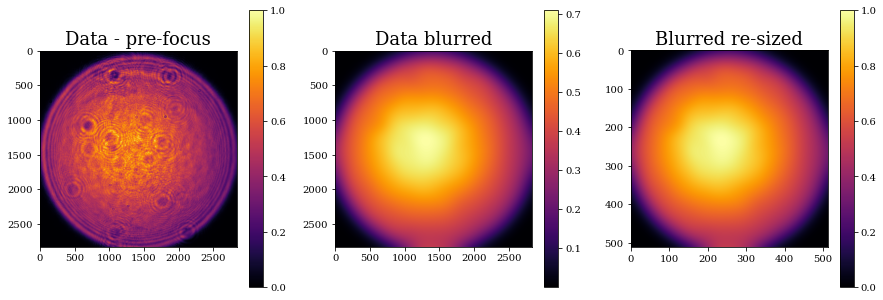

In [18]:
# In the setup, we have a fiber source. 
# Can model the intensity distribution using a Guassian or can just measure it directly
# Measuring directly also captures any mirror imperfections hindering transmission
intensity_dist = np.load(data_dir+"intensity/15_07_intensity_img_stack.npy")[0,:]
data = np.flipud(intensity_dist)

manual_lim = [1363,4203,386,3214]
data = data[manual_lim[2]:manual_lim[3], manual_lim[0]:manual_lim[1]]
data = (data - data.min())/(data.max()-data.min())

blurred = ski.filters.gaussian(data, sigma=(120, 120))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(data)
plt.title("Data - pre-focus")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(blurred)
plt.title("Data blurred")
plt.colorbar()
plt.subplot(1,3,3)
intensity_dist = resize(blurred, (aperture_npix, aperture_npix))
intensity_dist = (intensity_dist - intensity_dist.min())/(intensity_dist.max()-intensity_dist.min()) # re-map from 0-1
plt.title("Blurred re-sized")
plt.imshow(intensity_dist)
plt.colorbar()


#### System Aberrations 

We have an imperfect system. Load in the system aberrations (calculated using System_Aberrations.ipynb)

In [5]:
f_aberr = "data/spider/retrieval_results/16_09_mean_coeffs_combined.npy"
syst_noll = jnp.arange(4, 15) # only first 14 Zernike modes (excluding piston and tip/tilt) are used to classify syst aberrations
syst_coeffs = np.load(f_aberr)
syst_basis = dlu.zernike_basis(js=syst_noll, diameter=aperture_diameter, coordinates=coords)
print("System Coefficients (noll {}): {}".format(syst_noll,syst_coeffs))


System Coefficients (noll [ 4  5  6  7  8  9 10 11 12 13 14]): [ 5.34547523e-09 -7.48483795e-10  3.90298864e-09 -1.19804956e-09
 -7.88560215e-09  4.81785836e-09 -4.11487239e-09 -6.77422713e-09
  5.17982430e-11 -6.32650732e-10  1.59198803e-09]


In [6]:
class RotatingTransmissiveLayer(dl.layers.TransmissiveLayer):
    """
    Base class to hold transmissive layers imbuing them with a transmission and
    normalise parameter.

    ??? abstract "UML"
        ![UML](../../assets/uml/TransmissiveLayer.png)

    Attributes
    ----------
    transmission: Array
        The Array of transmission values to be applied to the input wavefront.
    normalise: bool
        Whether to normalise the wavefront after passing through the optic.
    rotation: Array([float])
        Single value for rotation of transmissive layer (radians). 
        Array of shape (1,) (zodiax artefact requires array to 
        optimise on single value). Rotation applied CW
    """

    rotation: np.array

    def __init__(
        self: dl.layers.optical_layers.OpticalLayer,
        transmission: np.array = None,
        normalise: bool = False,
        rotation: np.array = np.array([0.0]),
        **kwargs,
    ):
        """
        Parameters
        ----------
        transmission: Array = None
            The array of transmission values to be applied to the input wavefront.
        normalise : bool = False
            Whether to normalise the wavefront after passing through the optic.
        rotation: Array([float])
            Single value for rotation of transmissive layer (radians). 
            Array of shape (1,) (zodiax artefact requires array to 
            optimise on single value). Rotation applied CW
        """
        self.rotation = rotation
        super().__init__(transmission=transmission, normalise=normalise,**kwargs)

    def apply(self: dl.layers.optical_layers.OpticalLayer, wavefront: dl.wavefronts.Wavefront) -> dl.wavefronts.Wavefront:
        """
        Applies the layer to the wavefront.

        Parameters
        ----------
        wavefront : Wavefront
            The wavefront to operate on.

        Returns
        -------
        wavefront : Wavefront
            The transformed wavefront.
        """
        wavefront *= dlu.rotate(self.transmission, self.rotation) 
        if self.normalise:
            wavefront = wavefront.normalise()
        return wavefront


In [7]:
class OptimizablePointSource(dl.sources.Source):
    """
    Identical functionality to dLux PointSource - with a key difference
    that the flux parameter is held as a float array (0 grads when calc
    with Zodiax otherwise).

    ??? abstract "UML"
        ![UML](../../assets/uml/PointSource.png)

    Attributes
    ----------
    position : Array, radians
        The (x, y) on-sky position of this object.
    flux : Array, photons
        The flux of the object.
    spectrum : Spectrum
        The spectrum of this object, represented by a Spectrum object.
    """

    position: jnp.array
    flux: jnp.array

    def __init__(
        self: dl.sources.Source,
        wavelengths: jnp.array = None,
        position: jnp.array = jnp.zeros(2),
        flux: jnp.array = None,
        weights: jnp.array = None,
        spectrum: dl.Spectrum = None,
    ):
        """
        Parameters
        ----------
        wavelengths : Array, metres = None
            The array of wavelengths at which the spectrum is defined. This input is
            ignored if a Spectrum object is provided.
        position : Array, radians = np.zeros(2)
            The (x, y) on-sky position of this object.
        flux : float, photons = 1.
            The flux of the object.
        spectrum : Spectrum = None
            The spectrum of this object, represented by a Spectrum object.
        """
        # Position and Flux
        self.position = np.asarray(position, dtype=float)
        self.flux = jnp.asarray(flux, dtype=float)

        if self.position.shape != (2,):
            raise ValueError("position must be a 1d array of shape (2,).")

        super().__init__(
            wavelengths=wavelengths, weights=weights, spectrum=spectrum
        )

    def model(
        self: dl.sources.Source,
        optics: dl.optical_systems.BaseOpticalSystem,
        return_wf: bool = False,
        return_psf: bool = False,
    ) -> jnp.array:
        """
        Models the source object through the provided optics.

        Parameters
        ----------
        optics : Optics
            The optics through which to model the source object.
        return_wf : bool = False
            Should the Wavefront object be returned instead of the psf Array?
        return_psf : bool = False
            Should the PSF object be returned instead of the psf Array?

        Returns
        -------
        object : Array, Wavefront, PSF
            if `return_wf` is False and `return_psf` is False, returns the psf Array.
            if `return_wf` is True and `return_psf` is False, returns the Wavefront
                object.
            if `return_wf` is False and `return_psf` is True, returns the PSF object.
        """
        self = self.normalise()
        weights = self.weights * self.flux
        return optics.propagate(
            self.wavelengths, self.position, weights, return_wf, return_psf
        )



Plate + Spider setup simulated

Text(0.5, 1.0, 'Spider 180')

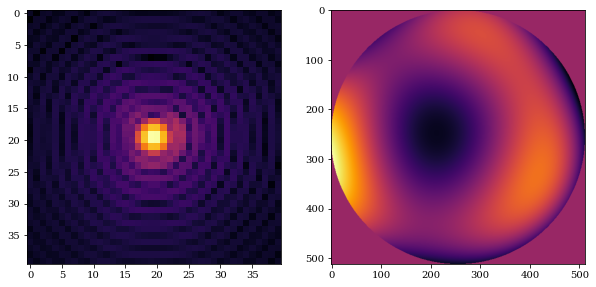

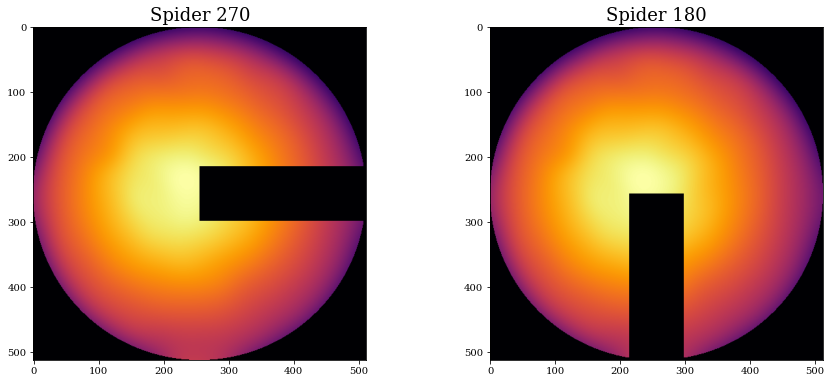

In [39]:
# Zernike aberrations
zernike_indicies = jnp.arange(4, 21) 
coeffs = jnp.zeros(zernike_indicies.shape)
basis = dlu.zernike_basis(js=zernike_indicies, coordinates=coords, diameter=aperture_diameter)

optical_systems = []
transmissions = []

# Using PointSources instead of single PointSource object to overcome float grad issue when solving for flux
# green_src = dl.PointSources(wavelengths=[green_laser_wl], flux =jnp.asarray([1e8],dtype=float))
# red_src = dl.PointSources(wavelengths=[red_laser_wl], flux =jnp.asarray([1e8],dtype=float))
green_src = OptimizablePointSource(wavelengths=[green_laser_wl], flux =jnp.asarray([1e8],dtype=float))
red_src = OptimizablePointSource(wavelengths=[red_laser_wl], flux =jnp.asarray([1e8],dtype=float))

spider_angles = [270, 180] #0deg is spider pointing vertically up, rotates CW from 0deg
optical_systems = []
transmissions = []
for i in range(len(spider_angles)):
    spider = dlu.spider(coords=coords, width=spider_width, angles=[spider_angles[i]])
    transmission = dlu.combine([circle, spider])

    layers = [
        ('SystemAberrations', dl.layers.BasisOptic(basis=syst_basis, coefficients=syst_coeffs, normalise=False)),
        ('intensity', dl.layers.TransmissiveLayer(transmission=intensity_dist, normalise=False)),
        ('spider', RotatingTransmissiveLayer(transmission=transmission, normalise=False)),
        ('aperture', dl.layers.BasisOptic(basis=basis, transmission=None, coefficients=coeffs, normalise=False)),
    ]

    optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)

    optical_systems.append(optics)
    transmissions.append(transmission)

# Construct Optics
optics_sp270  = optical_systems[0]
optics_sp180 = optical_systems[1]
# Check PSF for aberrated system
layers = [
    ('SystemAberrations', dl.layers.BasisOptic(syst_basis, circle*intensity_dist, syst_coeffs, normalise=False)),
]

optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                            diameter=wf_diam, 
                            layers=layers, 
                            psf_npixels=psf_npix, 
                            psf_pixel_scale=psf_pixel_scale,
                            oversample=oversample)

psf = optics.propagate_mono(green_laser_wl)
plt.subplot(1,2,1)
plt.imshow(psf**0.2)
opd = optics.SystemAberrations.eval_basis()
plt.subplot(1,2,2)
plt.imshow(opd)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow(optics_sp270.spider.transmission*optics_sp270.intensity.transmission)
plt.title("Spider 270")
plt.subplot(1,2,2)
plt.imshow(optics_sp180.spider.transmission*optics_sp180.intensity.transmission)
plt.title("Spider 180")

### Load in single Starphire data

#### Phase Retrieval

In [13]:
# version of jax.scipy.stats.logppmf where k can be non-discrete (helpful if data is not discrete photon counts)
from jax.scipy.special import xlogy, gammaln
from jax._src.lax.lax import _const as _lax_const
from jax import lax
from jax._src.numpy.util import promote_args_inexact

def jax_0_4_24_logpmf(k: jnp.array, mu: jnp.array, loc: jnp.array = 0) -> jnp.array:
    r"""Poisson log probability mass function.

    JAX implementation of :obj:`scipy.stats.poisson` ``logpmf``.

    The Poisson probability mass function is given by

    .. math::

        f(k) = e^{-\mu}\frac{\mu^k}{k!}

    and is defined for :math:`k \ge 0` and :math:`\mu \ge 0`.

    Args:
    k: arraylike, value at which to evaluate the PMF
    mu: arraylike, distribution shape parameter
    loc: arraylike, distribution offset parameter

    Returns:
    array of logpmf values.

    See Also:
    - :func:`jax.scipy.stats.poisson.cdf`
    - :func:`jax.scipy.stats.poisson.pmf`
    """
    k, mu, loc = promote_args_inexact("poisson.logpmf", k, mu, loc)
    zero = _lax_const(k, 0)
    x = lax.sub(k, loc)
    log_probs = xlogy(x, mu) - gammaln(x + 1) - mu
    #   return jnp.where(jnp.logical_or(lax.lt(x, zero),
    #                                   lax.ne(jnp.round(k), k)), -jnp.inf, log_probs)

    return jnp.where(lax.lt(x, zero), -jnp.inf, log_probs) # key diff in exit conditions to above

In [33]:
params = [
    'aperture.coefficients',
    'spider.rotation',
    'source.position',
    'source.flux', 
    ]

learning_rate = 1e-9
optimisers = [
            # # optax.adam(learning_rate=learning_rate),
            # optax.adam(learning_rate=1e-8),
            # # optax.sgd(learning_rate=1e-16),

            # # optax.adam(learning_rate=1e-5),
            # optax.adam(learning_rate=1e-7),
            # optax.adam(learning_rate=1e8),
            # optax.adam(learning_rate=learning_rate),
            optax.adam(learning_rate=1e-9),
            # optax.sgd(learning_rate=1e-16),

            optax.adam(learning_rate=1e-2),
            optax.adam(learning_rate=1e-8),
            optax.adam(learning_rate=1e7),
              ]

@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_poisson(model, data):

    simu_psf = model.model()

    # loss = -jsp.stats.poisson.logpmf(k=simu_psf, mu=data).sum()
    # loss = -jsp.stats.poisson.logpmf(k=data, mu=simu_psf).sum()
    # loss = -jax_0_4_24_logpmf(k=data, mu=simu_psf).sum()
    loss = ((data-simu_psf)**2).sum()

    return loss

@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_chi2(model, data):

    simu_psf = model.model()

    loss = ((simu_psf-data)**2/data).sum()

    return loss
@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_diff2(model, data):

    simu_psf = model.model()

    loss = ((data-simu_psf)**2).sum()

    return loss

@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_gauss(model, data, stdev):

    simu_psf = model.model()

    # loss = -jsp.stats.norm.logpdf(x=data, loc=simu_psf, scale=stdev).sum()
    loss = -jsp.stats.norm.logpdf(x=simu_psf, loc=data, scale=stdev).sum()


    return loss


### Lets loop this

#### Starphire 1

In [15]:
# Location on detector 
row_start, col_start = 1676, 2600 # Start coord of window on det where data was taken
row_len, col_len = 86, 76   # window size of recorded data

alpha_cropped = alpha[row_start:row_start+row_len, col_start:col_start+col_len]
beta_cropped = beta[row_start:row_start+row_len, col_start:col_start+col_len]
gamma_cropped = gamma[row_start:row_start+row_len, col_start:col_start+col_len]

# Order in increasing spider angle for each colour separately
img_fnames = [
    "non_glued/16_09_starphire1_green_0deg_400us_0gain_img_stack_batch_0.npy",
    "non_glued/16_09_starphire1_green_90deg_280us_0gain_img_stack_batch_0.npy",
    "non_glued/16_09_starphire1_red_0deg_294us_0gain_img_stack_batch_0.npy",
    "non_glued/16_09_starphire1_red_90deg_356us_0gain_img_stack_batch_0.npy",
    
]
labels = [
    "0deg_green",
    "90deg_green",
    "0deg_red",
    "90deg_red",
]
bckgnd_fnames = [
    "non_glued/16_09_starphire1_green_0deg_bckgnd_400us_0gain_img_stack_batch_0.npy",
    "non_glued/16_09_starphire1_green_90deg_bckgnd_280us_0gain_img_stack_batch_0.npy",
    "non_glued/16_09_starphire1_green_0deg_bckgnd_400us_0gain_img_stack_batch_0.npy",
    "non_glued/16_09_starphire1_green_90deg_bckgnd_280us_0gain_img_stack_batch_0.npy",
]
still_frame_idxs = [
    0, 0, 0, 0 # find_still_frame.py
]

imgs = np.asarray([np.flipud(np.load(data_dir+img_fname)) for img_fname in img_fnames])
bckgnds = np.asarray([np.mean(np.flipud(np.load(data_dir+bckgnd_fname)),axis=0) for bckgnd_fname in bckgnd_fnames])  # single bck

epochs = [
    5000, 5000,5000,5000,
]

Optimising on both spider orientations simultaneously 

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

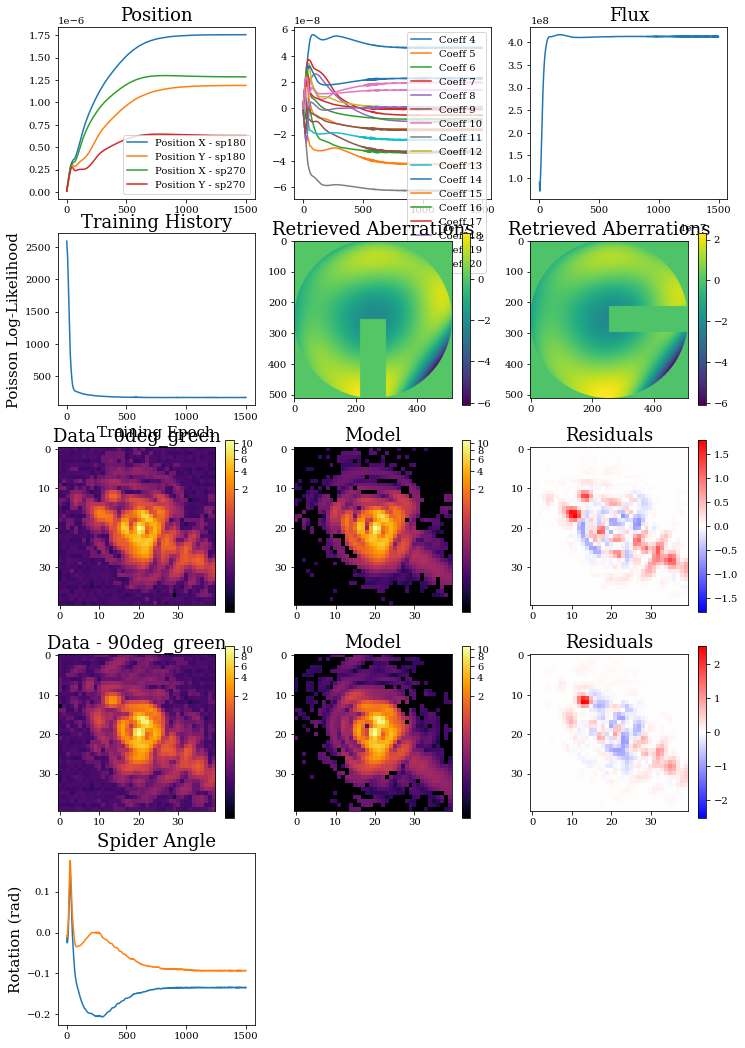

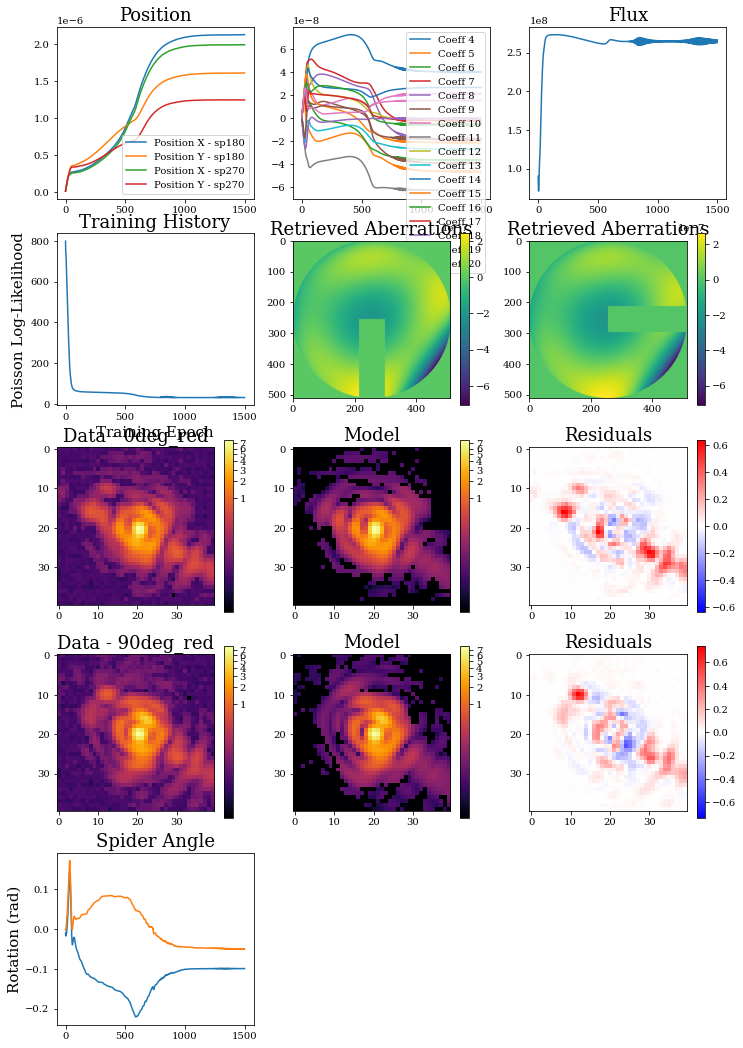

In [40]:
starphire1_coeffs, starphire1_pos = [], []

# 2 loops for 2 diff source colours
for i in range(2):
    data_idx = 2*i
    ###---------------------------- Re-init models ----------------------------###
    if i == 0:
        source = green_src
    else:
        source = red_src
    instrument_sp180 = dl.Telescope(optics_sp180, ('source', source))
    instrument_sp270 = dl.Telescope(optics_sp270, ('source', source))

    sim_psfs = [instrument_sp180.model(), instrument_sp270.model()]
    norm_psfs = [PowerNorm(0.2, vmax=sim_psf.max(), vmin=sim_psf.min()) for sim_psf in sim_psfs]    

    ###------------------------------- Get Data -----------------------------###
    data_sp180 = imgs[data_idx][still_frame_idxs[data_idx],:,:] #assuming only two spider configs, given in order of increasing angle for each colour
    data_sp270 = imgs[data_idx+1][still_frame_idxs[data_idx+1],:,:]
    data_list = [data_sp180, data_sp270]
    scaled_data_list = []
    for j in range(len(data_list)):
        data = data_list[j]
        data = data - bckgnds[j]

        # Reverse-model detector response
        data_remapped = 0.0 + ((1.0 - 0.0)/(data.max()-data.min()))*(data - data.min()) #[0,1] otput range
        data = np.power((data_remapped-np.flipud(alpha_cropped))/np.flipud(beta_cropped), (1/np.flipud(gamma_cropped))) # flip about origin

        # Scale intensity
        current_range = data.max() - data.min()
        new_range = sim_psfs[j].max() - sim_psfs[j].min()
        scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psfs[j].min()

        psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
        scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                    psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]
        
        scaled_data_list.append(scaled_data)
    ###------------------------------- Phase Retrieval -----------------------------###
    configs = [instrument_sp180, instrument_sp270]
    optim, opt_state = zdx.get_optimiser(instrument_sp180, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

    progress_bar = tqdm(range(1500), desc='Loss: ')

    # Run optimisation loop 
    net_losses, Coeffs, Positions_sp180, Positions_sp270, Fluxes, SpiderAngles= [],[],[],[],[],[]
    for j in progress_bar:
        grads = None
        net_loss = 0
        mean_coeff_grads, mean_position_grads, mean_flux_grads = None, None, None # to set initially in loop
        pos_grads = [] # update positional gradients separately (right now I've centered data based on brightest pixel
                        # but this is not a super robust method, so allow for source position difference)
        spider_grads = [] # acc for spider err rotation independently between configs
        for k in range(len(configs)):
            loss, grads = loss_fn_diff2(model = configs[k], data = scaled_data_list[k]) #loss_fn_poisson(model = configs[k], data = scaled_data_list[k])
            net_loss += loss 
            
            if k == 0:
                mean_coeff_grads = grads.aperture.coefficients/len(configs)
                mean_position_grads = grads.source.position/len(configs)
                mean_flux_grads = grads.source.flux/len(configs)
            else:
                mean_coeff_grads += grads.aperture.coefficients/len(configs)
                mean_position_grads += grads.source.position/len(configs)
                mean_flux_grads += grads.source.flux/len(configs)

            pos_grads.append(grads.source.position)
            spider_grads.append(grads.spider.rotation)

        grads = grads.set('aperture.coefficients', mean_coeff_grads)
        grads = grads.set('source.position', mean_position_grads)
        grads = grads.set('source.flux', mean_flux_grads)

        for k in range(len(configs)):
            grads = grads.set('source.position', pos_grads[k])
            grads = grads.set('spider.rotation', spider_grads[k])
            updates, opt_state = optim.update(grads, opt_state)
            configs[k] = zdx.apply_updates(configs[k], updates)

        net_losses.append(net_loss)
        Fluxes.append(configs[0].source.flux)
        Coeffs.append(configs[0].aperture.coefficients)
        Positions_sp180.append(configs[0].source.position)
        Positions_sp270.append(configs[1].source.position)
        SpiderAngles.append([configs[0].spider.rotation, configs[1].spider.rotation])

        progress_bar.set_postfix({'Loss (combined)': net_loss})

    ###---------------------------------- Plotting ---------------------------------###
    plt.figure(figsize=(12,18))
    plt.subplot(5,3,1)
    plt.plot(np.asarray(Positions_sp180)[:,0], label="Position X - sp180")
    plt.plot(np.asarray(Positions_sp180)[:,1], label="Position Y - sp180")
    plt.plot(np.asarray(Positions_sp270)[:,0], label="Position X - sp270")
    plt.plot(np.asarray(Positions_sp270)[:,1], label="Position Y - sp270")
    plt.title("Position")
    plt.legend()
    plt.subplot(5,3,2)
    arr_coeffs = np.asarray(Coeffs)
    for l in range(len(Coeffs[0])):
        label = "Coeff " + str(zernike_indicies[l])
        plt.plot(arr_coeffs[:,l], label=label)
    plt.legend()
    plt.subplot(5,3,3)
    plt.plot(np.asarray(Fluxes))
    plt.title("Flux")
    plt.subplot(5,3,4)
    plt.plot(np.array(net_losses))
    ax = plt.gca()
    ax.set_title("Training History")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("Poisson Log-Likelihood")

    it = 5
    for k, config in enumerate(configs):
        plt.subplot(5,3,it)
        opd = config.aperture.eval_basis()
        trans = config.spider.transmission
        plt.imshow(opd*trans, cmap='viridis')
        plt.title('Retrieved Aberrations')
        plt.colorbar()
        it+=1

    for k, config in enumerate(configs):
        scaled_data = scaled_data_list[k]
        instrument = config

        plt.subplot(5,3,it)
        norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
        plt.imshow(scaled_data, norm=norm_psf)
        plt.colorbar()
        plt.title('Data - '+labels[data_idx+k])
        it+=1

        plt.subplot(5,3,it)
        model_psf = instrument.model()
        current_range = model_psf.max() - model_psf.min()
        new_range = scaled_data.max() - scaled_data.min()
        model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
        norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
        mask = np.ones(scaled_data.shape)
        mask[scaled_data < 0.01] = 0
        plt.imshow(model_psf*mask, norm=norm_psf)
        plt.title('Model')
        plt.colorbar()
        it+=1

        plt.subplot(5,3,it)
        resid = scaled_data - model_psf
        plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
        plt.colorbar()
        plt.title('Residuals')
        it+=1
   
    plt.subplot(5,3,it)
    spider_angles_arr = np.asarray(SpiderAngles)
    plt.plot(spider_angles_arr[:,0], label="config0")
    plt.plot(spider_angles_arr[:,1], label="config0")
    plt.title("Spider Angle")
    plt.ylabel("Rotation (rad)")

    starphire1_coeffs.append(configs[0].aperture.coefficients) # identical coeffs for both configs
    starphire1_pos.append([configs[0].source.position, configs[1].source.position])


Optimising on each config individually

In [ ]:
# starphire1_coeffs, starphire1_pos = [], []

# # no error bars, individual orientation fitting TODO sems all frames - not sure how to do simulatenous opt with mult images
# for i in range(len(img_fnames)): 
#     ###---------------------------- Re-init model ----------------------------###
#     if '_0deg_' in img_fnames[i]:
#         optics = optics_sp180
#     elif '_90deg_' in img_fnames[i]:
#         optics = optics_sp270
#     else:
#         ValueError("Unknown File format")

#     if 'green' in img_fnames[i]:
#         src = green_src
#     elif 'red' in img_fnames[i]:
#         src = red_src
#     else:
#         ValueError("Unknown File format")

#     instrument = dl.Telescope(optics, ('source', src))
#     sim_psf = instrument.model()
#     norm_psf = PowerNorm(0.2, vmax=sim_psf.max(), vmin=sim_psf.min())

#     ###------------------------------- Load data -----------------------------###
#     data = np.load(img_fnames[i])
#     data = data[still_frame_idxs[i],:,:] # using the most still frame (find_still_frame.py)

#     bckgnd = np.load(bckgnd_fnames[i])
#     bckgnd = np.mean(bckgnd)
#     data = data - bckgnd

#     data_remapped = 0.0 + ((1.0 - 0.0)/(data.max()-data.min()))*(data - data.min()) #[0,1] otput range
#     data_lin = np.power((data_remapped-np.flip(alpha_cropped))/np.flip(beta_cropped), (1/np.flip(gamma_cropped))) # flip about origin

#     # Scale intensity
#     data = data_lin
#     current_range = data.max() - data.min()
#     new_range = sim_psf.max() - sim_psf.min()
#     scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psf.min()

#     psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
#     scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
#                                 psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]

#     plt.figure(figsize=(10,5))
#     plt.subplot(1,2,1)
#     plt.imshow(scaled_data, norm=norm_psf)
#     plt.colorbar()
#     plt.title("Data (scaled)")
#     plt.subplot(1,2,2)
#     plt.imshow(sim_psf, norm=norm_psf)
#     plt.colorbar()
#     plt.title("Simulated")

#     ###------------------------------- Phase Retrieval -----------------------------###
#     optim, opt_state = zdx.get_optimiser(instrument, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

#     progress_bar = tqdm(range(epochs[i]), desc='Loss: ')

#     # Run optimisation loop 
#     net_losses, Coeffs, Positions, Fluxes= [],[],[],[]
#     for j in progress_bar:
#         poiss_loss, poiss_grads = loss_fn_poisson(model = instrument, data = scaled_data)

#         updates, opt_state = optim.update(poiss_grads, opt_state)
#         instrument = zdx.apply_updates(instrument, updates) 

#         net_losses.append(poiss_loss)
#         Fluxes.append(instrument.source.flux)
#         Coeffs.append(instrument.aperture.coefficients)
#         Positions.append(instrument.source.position)

#         progress_bar.set_postfix({'Loss': poiss_loss})
#     ###---------------------------------- Plotting ---------------------------------###
#     plt.figure(figsize=(11,3))
#     plt.subplot(1,4,1)
#     plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
#     plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
#     plt.title("Position")
#     plt.legend()
#     plt.subplot(1,4,2)
#     arr_coeffs = np.asarray(Coeffs)
#     for k in range(len(Coeffs[0])):
#         label = "Coeff " + str(zernike_indicies[k])
#         plt.plot(arr_coeffs[:,k], label=label)
#     plt.legend()
#     plt.subplot(1,4,3)
#     plt.plot(np.asarray(Fluxes))
#     plt.title("Flux")
#     plt.subplot(1,4,4)
#     plt.plot(np.array(net_losses))
#     ax = plt.gca()
#     ax.set_title("Training History")
#     ax.set_xlabel("Training Epoch")
#     ax.set_ylabel("Poisson Log-Likelihood")


#     plt.figure(figsize=(12,10))
#     norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
#     plt.subplot(2,2,1)
#     plt.imshow(scaled_data, norm=norm_psf)
#     plt.colorbar()
#     plt.title('Data')

#     plt.subplot(2,2,2)
#     model_psf = instrument.model()
#     current_range = model_psf.max() - model_psf.min()
#     new_range = scaled_data.max() - scaled_data.min()
#     model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
#     norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
#     mask = np.ones(scaled_data.shape)
#     mask[scaled_data < 0.01] = 0
#     plt.imshow(model_psf*mask, norm=norm_psf)
#     plt.title('Model')
#     plt.colorbar()

#     plt.subplot(2,2,3)
#     resid = scaled_data - model_psf
#     plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
#     plt.colorbar()
#     plt.title('Residuals')

#     plt.subplot(2,2,4)
#     opd = instrument.aperture.eval_basis()
#     transmission = instrument.aperture.transmission 
#     plt.imshow(opd*transmission, cmap='viridis')
#     plt.title('Retrieved Aberrations')
#     plt.colorbar()


#     print("Optimised Position: {}\nFlux: {}\nCoefficients: {}".format(instrument.source.position, instrument.source.flux, instrument.aperture.coefficients))

#     starphire1_coeffs.append(instrument.aperture.coefficients)
#     starphire1_pos.append(instrument.source.position)


In [ ]:
# Plot 
# WFE calc excluding piston, tip and tilt
plt.figure(figsize=(10,5))
wf_errs = []
labels = ['green', 'red']
# OR (depending on optimisation config)
# labels = [
#     "0deg_green",
#     "90deg_green",
#     "0deg_red",
#     "90deg_red",
# ]
for i,coeffs in enumerate(starphire1_coeffs):

    if 'red' in labels[i]:
        wl = red_laser_wl
        colour = 'r'
    elif 'green' in labels[i]:
        wl = green_laser_wl
        colour = 'g'
    else:
        ValueError("Unknown Wavelength")

    plt.scatter(zernike_indicies, coeffs, label=labels[i], c=colour)
    RMS_wf_err = ((coeffs**2).sum())**0.5

    print("{} RMS WFE: {:.3f}lambda".format(labels[i], RMS_wf_err/wl))
    wf_errs.append(RMS_wf_err/wl) 

plt.xlabel("Zernike Noll Index")
plt.ylabel("Coefficient (m)")
plt.grid()
plt.legend()

print("Mean RMS WFE: {:.3f}lambda".format(np.mean(wf_errs)))

Add Zernike coeff uncertainties once sure this is calc correctly

#### Starphire 2

In [41]:
img_fnames = [
    data_dir+"non_glued/16_09_starphire2_green_0deg_173us_0gain_img_stack_batch_0.npy",
    data_dir+"non_glued/16_09_starphire2_green_90deg_294us_0gain_img_stack_batch_0.npy",
    data_dir+"non_glued/16_09_starphire2_red_0deg_173us_0gain_img_stack_batch_0.npy",
    data_dir+"non_glued/16_09_starphire2_red_90deg_173us_0gain_img_stack_batch_0.npy",
    
]
labels = [
    "0deg_green",
    "90deg_green",
    "0deg_red",
    "90deg_red",
]
bckgnd_fnames = [
    data_dir+"non_glued/16_09_starphire2_green_0deg_bckgnd_173us_0gain_img_stack_batch_0.npy",
    data_dir+"non_glued/16_09_starphire2_red_90deg_bckgnd_173us_0gain_img_stack_batch_0.npy",
    data_dir+"non_glued/16_09_starphire2_green_0deg_bckgnd_173us_0gain_img_stack_batch_0.npy",
    data_dir+"non_glued/16_09_starphire2_red_90deg_bckgnd_173us_0gain_img_stack_batch_0.npy",
]
still_frame_idxs = [
    151, 163, 84, 113 # find_still_frame.py
]
imgs = np.asarray([np.flipud(np.load(img_fname)) for img_fname in img_fnames])
bckgnds = np.asarray([np.mean(np.flipud(np.load(bckgnd_fname)),axis=0) for bckgnd_fname in bckgnd_fnames]) 

epochs = [
    5000, 5000,5000,5000,
]

Loss:   0%|          | 0/2000 [00:00<?, ?it/s]

Loss:   0%|          | 0/2000 [00:00<?, ?it/s]

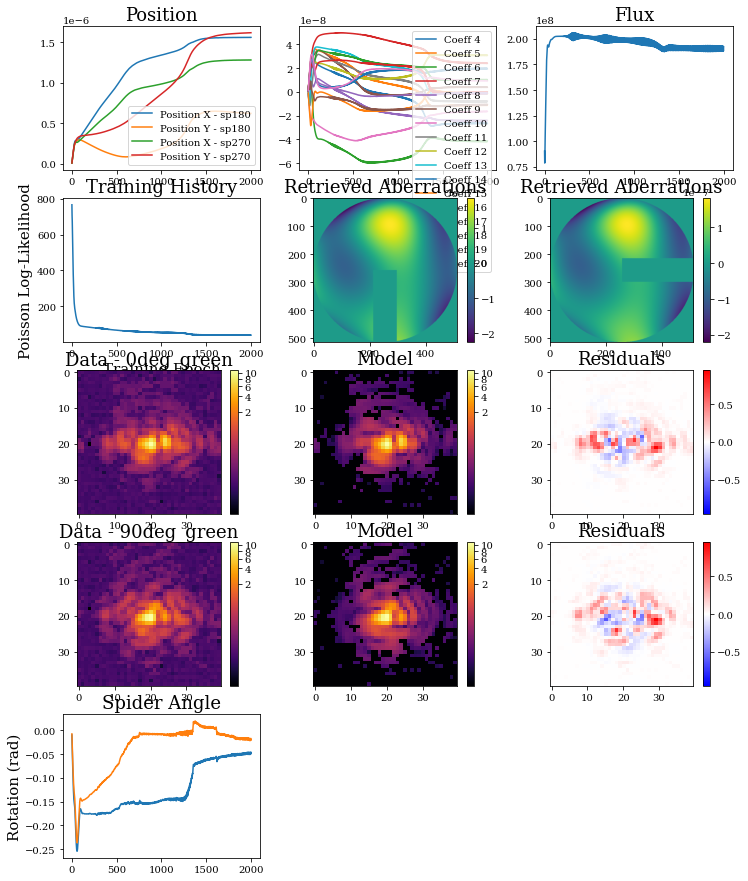

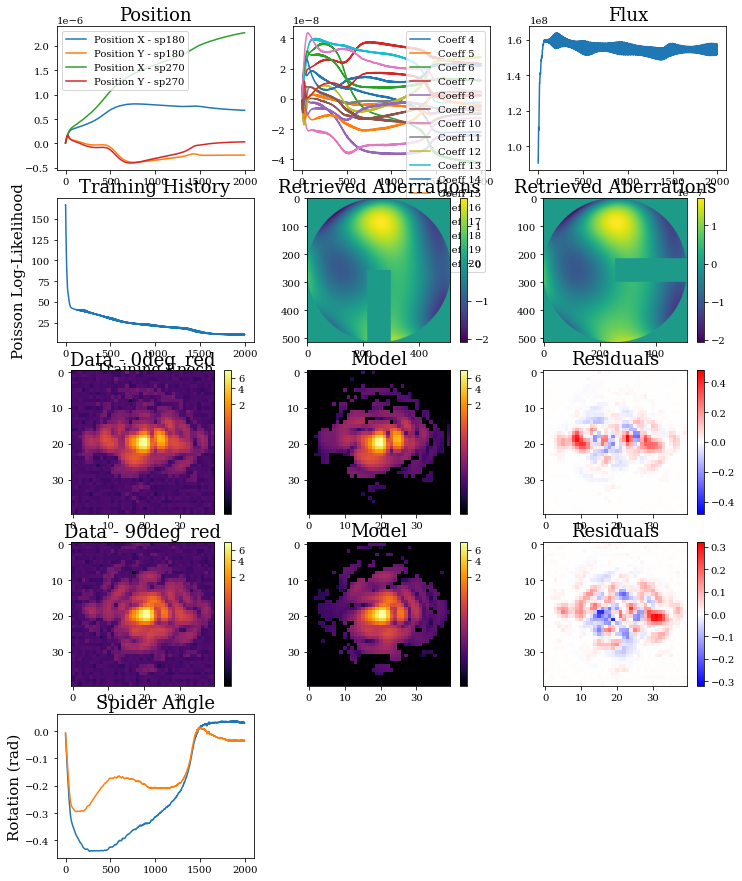

In [43]:
starphire2_coeffs, starphire2_pos = [], []

# 2 loops for 2 diff source colours
for i in range(2):
    ###---------------------------- Re-init models ----------------------------###
    if i == 0:
        source = green_src
    else:
        source = red_src
    instrument_sp180 = dl.Telescope(optics_sp180, ('source', source))
    instrument_sp270 = dl.Telescope(optics_sp270, ('source', source))

    sim_psfs = [instrument_sp180.model(), instrument_sp270.model()]
    norm_psfs = [PowerNorm(0.2, vmax=sim_psf.max(), vmin=sim_psf.min()) for sim_psf in sim_psfs]    

    ###------------------------------- Get Data -----------------------------###
    data_idx = 2*i
    data_sp180 = imgs[data_idx][still_frame_idxs[data_idx],:,:] #assuming only two spider configs, given in order of increasing angle for each colour
    data_sp270 = imgs[data_idx+1][still_frame_idxs[data_idx+1],:,:]
    data_list = [data_sp180, data_sp270]
    scaled_data_list = []
    for j in range(len(data_list)):
        data = data_list[j]
        data = data - bckgnds[j]

        # Reverse-model detector response
        data_remapped = 0.0 + ((1.0 - 0.0)/(data.max()-data.min()))*(data - data.min()) #[0,1] otput range
        data = np.power((data_remapped-np.flip(alpha_cropped))/np.flip(beta_cropped), (1/np.flip(gamma_cropped))) # flip about origin

        # Scale intensity
        current_range = data.max() - data.min()
        new_range = sim_psfs[j].max() - sim_psfs[j].min()
        scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psfs[j].min()

        psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
        scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                    psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]
        
        scaled_data_list.append(scaled_data)
    ###------------------------------- Phase Retrieval -----------------------------###
    configs = [instrument_sp180, instrument_sp270]
    optim, opt_state = zdx.get_optimiser(instrument_sp180, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

    progress_bar = tqdm(range(2000), desc='Loss: ')

    # Run optimisation loop 
    net_losses, Coeffs, Positions_sp180, Positions_sp270, Fluxes, SpiderAngles= [],[],[],[],[],[]
    for j in progress_bar:
        grads = None
        net_loss = 0
        mean_coeff_grads, mean_position_grads, mean_flux_grads = None, None, None # to set initially in loop
        pos_grads = [] # update positional gradients separately (right now I've centered data based on brightest pixel
                        # but this is not a super robust method, so allow for source position difference)
        spider_grads = [] # acc for spider err rotation independently between configs
        for k in range(len(configs)):
            loss, grads = loss_fn_diff2(model = configs[k], data = scaled_data_list[k])
            net_loss += loss 
            
            if k == 0:
                mean_coeff_grads = grads.aperture.coefficients/len(configs)
                mean_position_grads = grads.source.position/len(configs)
                mean_flux_grads = grads.source.flux/len(configs)
            else:
                mean_coeff_grads += grads.aperture.coefficients/len(configs)
                mean_position_grads += grads.source.position/len(configs)
                mean_flux_grads += grads.source.flux/len(configs)

            pos_grads.append(grads.source.position)
            spider_grads.append(grads.spider.rotation)

        grads = grads.set('aperture.coefficients', mean_coeff_grads)
        grads = grads.set('source.position', mean_position_grads)
        grads = grads.set('source.flux', mean_flux_grads)

        for k in range(len(configs)):
            grads = grads.set('source.position', pos_grads[k])
            grads = grads.set('spider.rotation', spider_grads[k])
            updates, opt_state = optim.update(grads, opt_state)
            configs[k] = zdx.apply_updates(configs[k], updates)

        net_losses.append(net_loss)
        Fluxes.append(configs[0].source.flux)
        Coeffs.append(configs[0].aperture.coefficients)
        Positions_sp180.append(configs[0].source.position)
        Positions_sp270.append(configs[1].source.position)
        SpiderAngles.append([configs[0].spider.rotation, configs[1].spider.rotation])

        progress_bar.set_postfix({'Loss (combined)': net_loss})

    ###---------------------------------- Plotting ---------------------------------###
    plt.figure(figsize=(12,15))
    plt.subplot(5,3,1)
    plt.plot(np.asarray(Positions_sp180)[:,0], label="Position X - sp180")
    plt.plot(np.asarray(Positions_sp180)[:,1], label="Position Y - sp180")
    plt.plot(np.asarray(Positions_sp270)[:,0], label="Position X - sp270")
    plt.plot(np.asarray(Positions_sp270)[:,1], label="Position Y - sp270")
    plt.title("Position")
    plt.legend()
    plt.subplot(5,3,2)
    arr_coeffs = np.asarray(Coeffs)
    for l in range(len(Coeffs[0])):
        label = "Coeff " + str(zernike_indicies[l])
        plt.plot(arr_coeffs[:,l], label=label)
    plt.legend()
    plt.subplot(5,3,3)
    plt.plot(np.asarray(Fluxes))
    plt.title("Flux")
    plt.subplot(5,3,4)
    plt.plot(np.array(net_losses))
    ax = plt.gca()
    ax.set_title("Training History")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("Poisson Log-Likelihood")

    it = 5
    for k, config in enumerate(configs):
        plt.subplot(5,3,it)
        opd = config.aperture.eval_basis()
        trans = config.spider.transmission
        plt.imshow(opd*trans, cmap='viridis')
        plt.title('Retrieved Aberrations')
        plt.colorbar()
        it+=1

    for k, config in enumerate(configs):
        scaled_data = scaled_data_list[k]
        instrument = config

        plt.subplot(5,3,it)
        norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
        plt.imshow(scaled_data, norm=norm_psf)
        plt.colorbar()
        plt.title('Data - '+labels[data_idx+k])
        it+=1

        plt.subplot(5,3,it)
        model_psf = instrument.model()
        current_range = model_psf.max() - model_psf.min()
        new_range = scaled_data.max() - scaled_data.min()
        model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
        norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
        mask = np.ones(scaled_data.shape)
        mask[scaled_data < 0.01] = 0
        plt.imshow(model_psf*mask, norm=norm_psf)
        plt.title('Model')
        plt.colorbar()
        it+=1

        plt.subplot(5,3,it)
        resid = scaled_data - model_psf
        plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
        plt.colorbar()
        plt.title('Residuals')
        it+=1
   
    plt.subplot(5,3,it)
    spider_angles_arr = np.asarray(SpiderAngles)
    plt.plot(spider_angles_arr[:,0], label="config0")
    plt.plot(spider_angles_arr[:,1], label="config0")
    plt.title("Spider Angle")
    plt.ylabel("Rotation (rad)")

   
    starphire2_coeffs.append(configs[0].aperture.coefficients) # identical coeffs for both configs
    starphire2_pos.append([configs[0].source.position, configs[1].source.position])


In [ ]:
# Plot 
# WFE calc excluding piston, tip and tilt
plt.figure(figsize=(10,5))
wf_errs = []
labels = ['green', 'red']
for i,coeffs in enumerate(starphire2_coeffs):
    if 'red' in labels[i]:
        wl = red_laser_wl
        colour = 'r'
    elif 'green' in labels[i]:
        wl = green_laser_wl
        colour = 'g'
    else:
        ValueError("Unknown Wavelength")

    plt.scatter(zernike_indicies, coeffs, label=labels[i], c=colour)
    RMS_wf_err = ((coeffs**2).sum())**0.5

    print("{} RMS WFE: {:.3f}lambda".format(labels[i], RMS_wf_err/wl))
    wf_errs.append(RMS_wf_err/wl) 

plt.xlabel("Zernike Noll Index")
plt.ylabel("Coefficient (m)")
plt.grid()
plt.legend()

print("Mean RMS WFE: {:.3f}lambda".format(np.mean(wf_errs)))

Comparing plates

In [ ]:
plt.figure(figsize=(15,5))
titles = ["Green Data", "Red Data"]
wls = [green_laser_wl, red_laser_wl]   

subplt_it = 1
for i in range(len(titles)):
    plt.subplot(1,2,subplt_it)
    plt.title(titles[i])
    plt.scatter(zernike_indicies, starphire1_coeffs[i]/wls[i], label="Starphire 1")
    plt.scatter(zernike_indicies, starphire2_coeffs[i]/wls[i], label="Starphire 2")

    plt.xlabel("Zernike Noll Index")
    plt.ylabel("OPD (multiple of wl)")
    plt.legend()
    plt.grid()

    subplt_it+=1


______________________________________________________________________________________________________________________________________________________________________________________________

#### Glued plates



New intensity dist

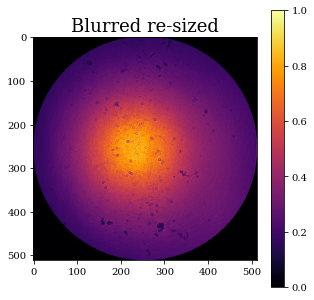

In [47]:
intensity_dist = np.load(data_dir+"intensity/dithered_12_24_1sig.npy")
plt.figure(figsize=(5,5))
plt.title("Blurred re-sized")
plt.imshow(intensity_dist)
plt.colorbar()

New syst aberrations (glued data taken three months after)

In [45]:
f_aberr = "data/spider/retrieval_results/3_01_mean_coeffs_combined.npy"#"data/spider/retrieval_results/17_12_mean_coeffs_combined.npy"
syst_noll = jnp.arange(4, 15) # only first 14 Zernike modes (excluding piston and tip/tilt) are used to classify syst aberrations
syst_coeffs = np.load(f_aberr)
syst_basis = dlu.zernike_basis(js=syst_noll, diameter=aperture_diameter, coordinates=coords)
print("System Coefficients (noll {}): {}".format(syst_noll,syst_coeffs))

System Coefficients (noll [ 4  5  6  7  8  9 10 11 12 13 14]): [ 1.77768871e-08 -6.29380383e-09  1.57756364e-08  2.62230405e-09
 -9.55459674e-10  1.53447510e-08 -9.32570161e-09 -3.50553780e-08
  1.46056251e-09 -8.53224531e-10  1.08097446e-08]


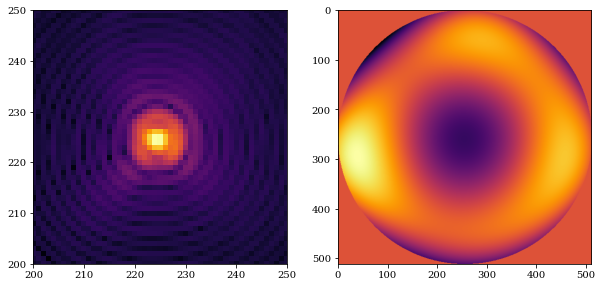

In [48]:
# Re-create base models with new syst aberrations
psf_npix = 450                 # Number of pixels along one dim of the PSF
psf_hlf_sz = int(psf_npix/2)   # half window sz of cropped data
coeffs = jnp.zeros(zernike_indicies.shape)
optical_systems = []
transmissions = []
for i in range(len(spider_angles)):
    spider = dlu.spider(coords=coords, width=spider_width, angles=[spider_angles[i]])
    transmission = dlu.combine([circle, spider])

    layers = [
        ('SystemAberrations', dl.layers.BasisOptic(basis=syst_basis, coefficients=syst_coeffs, normalise=False)),
        ('intensity', dl.layers.TransmissiveLayer(transmission=intensity_dist, normalise=False)),
        ('spider', RotatingTransmissiveLayer(transmission=transmission, normalise=False)),
        ('aperture', dl.layers.BasisOptic(basis=basis, transmission=None, coefficients=coeffs, normalise=False)),
    ]
    optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)

    optical_systems.append(optics)
    transmissions.append(transmission)

# Construct Optics
optics_sp270  = optical_systems[0]
optics_sp180 = optical_systems[1]

# Check PSF for aberrated system
layers = [
    ('SystemAberrations', dl.layers.BasisOptic(syst_basis, circle*intensity_dist, syst_coeffs, normalise=False)),
]

optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                            diameter=wf_diam, 
                            layers=layers, 
                            psf_npixels=psf_npix, 
                            psf_pixel_scale=psf_pixel_scale,
                            oversample=oversample)

psf = optics.propagate_mono(green_laser_wl)
plt.subplot(1,2,1)
plt.imshow(psf**0.2)
plt.xlim([200,250])
plt.ylim([200,250])
opd = optics.SystemAberrations.eval_basis()
plt.subplot(1,2,2)
plt.imshow(opd)


In [12]:
row_start, col_start = 1324, 2184 # Start coord of window on det where data was taken
row_len, col_len = 510, 568   # window size of recorded data

alpha_cropped = alpha[row_start:row_start+row_len, col_start:col_start+col_len]
beta_cropped = beta[row_start:row_start+row_len, col_start:col_start+col_len]
gamma_cropped = gamma[row_start:row_start+row_len, col_start:col_start+col_len]

# Order in increasing spider angle for each colour separately
img_fnames = [
    "glued/17_12_green_0deg_img_80us_0gain_img_stack_batch_0.npy",
    "glued/17_12_green_90deg_img_80us_0gain_img_stack_batch_0.npy",
    "glued/17_12_red_0deg_img_80us_0gain_img_stack_batch_0.npy",
    "glued/17_12_red_90deg_img_80us_0gain_img_stack_batch_0.npy",

]

labels = [
    "0deg_green",
    "90deg_green",
    "0deg_red",
    "90deg_red",
]
bckgnd_fnames = [
    "glued/17_12_green_0deg_img_bckgnd_80us_0gain_img_stack_batch_0.npy",
    "glued/17_12_green_90deg_img_bckgnd_80us_0gain_img_stack_batch_0.npy",
    "glued/17_12_red_0deg_img_bckgnd_80us_0gain_img_stack_batch_0.npy",
    "glued/17_12_red_90deg_img_bckgnd_80us_0gain_img_stack_batch_0.npy",
]
still_frame_idxs = [
    0, 0, 0, 0 # find_still_frame.py
]

imgs = np.asarray([np.flipud(np.load(data_dir +img_fname)) for img_fname in img_fnames])
bckgnds = np.asarray([np.mean(np.flipud(np.load(data_dir +bckgnd_fname)),axis=0) for bckgnd_fname in bckgnd_fnames])  # single bck


Loss:   0%|          | 0/200 [00:00<?, ?it/s]

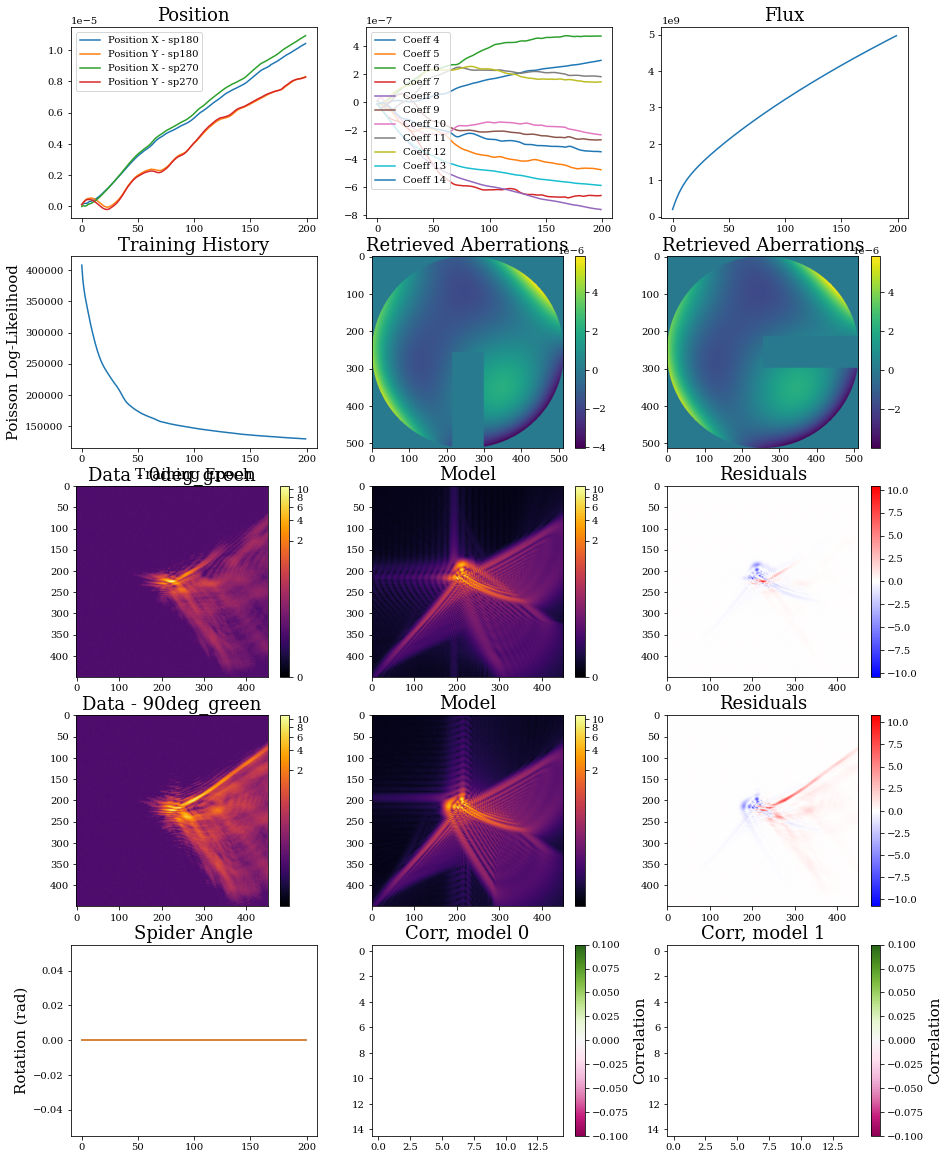

In [21]:
glued_coeffs, glued_source_pos = [], []
final_pos, final_spider_angle = [], [] #[0deg green, 90deg green, 0deg red, 90deg red]

np.random.seed(0)
rand_coeffs = np.random.rand(7)*1e-6
coeffs = np.zeros(zernike_indicies.shape)
appen = np.zeros(shape=(coeffs.shape[0] - rand_coeffs.shape[0],))
rand_coeffs = np.concatenate((rand_coeffs,appen))

# 2 loops for 2 diff source colours
for i in range(1):
    ###--------------------------- Re-init models ----------------------------###
    if i == 0:
        source = green_src
    else:
        source = red_src
    instrument_sp180 = dl.Telescope(optics_sp180, ('source', source))
    instrument_sp270 = dl.Telescope(optics_sp270, ('source', source))

    # # start from different aberration point
    # instrument_sp180 = instrument_sp180.set("aperture.coefficients", -rand_coeffs)
    # instrument_sp270 = instrument_sp270.set("aperture.coefficients", -rand_coeffs)

    sim_psfs = [instrument_sp180.model(), instrument_sp270.model()]
    norm_psfs = [PowerNorm(0.2, vmax=sim_psf.max(), vmin=sim_psf.min()) for sim_psf in sim_psfs]    

    ###------------------------------- Get Data -----------------------------###
    data_idx = 2*i
    data_sp180 = imgs[data_idx]#[still_frame_idxs[data_idx],:,:] #assuming only two spider configs, given in order of increasing angle for each colour
    data_sp270 = imgs[data_idx+1]#[still_frame_idxs[data_idx+1],:,:]
    data_list = [data_sp180, data_sp270]
    scaled_data_list = []
    scaled_stdev_list = []
    for j in range(len(data_list)):
        data = data_list[j]
        data = data - bckgnds[j]

        # Reverse-model detector response
        scaled_cube=[]
        for frame in data:
            data_remapped = 0.0 + ((1.0 - 0.0)/(frame.max()-frame.min()))*(frame - frame.min()) #[0,1] otput range
            data = np.power((data_remapped-np.flip(alpha_cropped))/np.flip(beta_cropped), (1/np.flip(gamma_cropped))) # flip about origin

            # Scale intensity
            current_range = data.max() - data.min()
            new_range = sim_psfs[j].max() - sim_psfs[j].min()
            scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psfs[j].min()
            scaled_cube.append(scaled_data)
            
        scaled_cube = np.asarray(scaled_cube)
        stdev = np.std(scaled_cube, axis=0)
        picked_frame = scaled_cube[0]
        psf_center_idx = np.unravel_index(np.argmax(picked_frame, axis=None), picked_frame.shape)
        picked_frame = picked_frame[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                    psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]
        stdev = stdev[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]
        
        
        scaled_stdev_list.append(stdev)
        scaled_data_list.append(picked_frame)
    ###------------------------------- Phase Retrieval -----------------------------###
    configs = [instrument_sp180, instrument_sp270]
    optim, opt_state = zdx.get_optimiser(instrument_sp180, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

    progress_bar = tqdm(range(200), desc='Loss: ')

    # Run optimisation loop 
    net_losses, Coeffs, Positions_sp180, Positions_sp270, Fluxes, SpiderAngles= [],[],[],[],[],[]
    for j in progress_bar:
        grads = None
        net_loss = 0
        mean_coeff_grads, mean_position_grads, mean_flux_grads = None, None, None # to set initially in loop
        pos_grads = [] # update positional gradients separately (right now I've centered data based on brightest pixel
                        # but this is not a super robust method, so allow for source position difference)
        spider_grads = [] # acc for spider err rotation independently between configs
        for k in range(len(configs)):
            loss, grads =  loss_fn_poisson(model = configs[k], data = scaled_data_list[k])
            net_loss += loss 
            
            if k == 0:
                mean_coeff_grads = grads.aperture.coefficients/len(configs)
                mean_position_grads = grads.source.position/len(configs)
                mean_flux_grads = grads.source.flux/len(configs)
            else:
                mean_coeff_grads += grads.aperture.coefficients/len(configs)
                mean_position_grads += grads.source.position/len(configs)
                mean_flux_grads += grads.source.flux/len(configs)

            pos_grads.append(grads.source.position)
            spider_grads.append(grads.spider.rotation)

        grads = grads.set('aperture.coefficients', mean_coeff_grads)
        # grads = grads.set('source.position', mean_position_grads)
        grads = grads.set('source.flux', mean_flux_grads)

        for k in range(len(configs)):
            grads = grads.set('source.position', pos_grads[k])
            grads = grads.set('spider.rotation', spider_grads[k])
            updates, opt_state = optim.update(grads, opt_state)
            configs[k] = zdx.apply_updates(configs[k], updates)

        net_losses.append(net_loss)
        Fluxes.append(configs[0].source.flux)
        Coeffs.append(configs[0].aperture.coefficients)
        Positions_sp180.append(configs[0].source.position)
        Positions_sp270.append(configs[1].source.position)
        SpiderAngles.append([configs[0].spider.rotation, configs[1].spider.rotation])

        progress_bar.set_postfix({'Loss (combined)': net_loss})

    ###------------------------------ Correlation Matrix ---------------------------###
    corr_matrices = []
    for k in range(len(configs)):
        cov = zdx.self_covariance_matrix(pytree=configs[k],
                                         parameters=['spider.rotation', 'source.flux', 'source.position', 'aperture.coefficients'],
                                         loglike_fn=zdx.bayes.poiss_loglike,
                                         )
        sqrt_cov = cov**0.5 # for stdevs
        corr = np.zeros(shape=cov.shape)
        for i in range(cov.shape[0]):
            for j in range(cov.shape[0]):
                corr[i,j] = cov[i,j]/(sqrt_cov[i,i]*sqrt_cov[j,j])

        corr_matrices.append(corr)

    ###---------------------------------- Plotting ---------------------------------###
    plt.figure(figsize=(15,20))
    plt.subplot(5,3,1)
    plt.plot(np.asarray(Positions_sp180)[:,0], label="Position X - sp180")
    plt.plot(np.asarray(Positions_sp180)[:,1], label="Position Y - sp180")
    plt.plot(np.asarray(Positions_sp270)[:,0], label="Position X - sp270")
    plt.plot(np.asarray(Positions_sp270)[:,1], label="Position Y - sp270")
    plt.title("Position")
    final_pos.append([np.asarray(Positions_sp180)[-1,0], np.asarray(Positions_sp180)[-1,1]])
    final_pos.append([np.asarray(Positions_sp270)[-1,0], np.asarray(Positions_sp270)[-1,1]])

    plt.legend()
    plt.subplot(5,3,2)
    arr_coeffs = np.asarray(Coeffs)
    for l in range(len(Coeffs[0])):
        label = "Coeff " + str(zernike_indicies[l])
        plt.plot(arr_coeffs[:,l], label=label)
    plt.legend(loc='upper left')
    plt.subplot(5,3,3)
    plt.plot(np.asarray(Fluxes))
    plt.title("Flux")
    plt.subplot(5,3,4)
    plt.plot(np.array(net_losses))
    ax = plt.gca()
    ax.set_title("Training History")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("Poisson Log-Likelihood")

    it = 5
    for k, config in enumerate(configs):
        plt.subplot(5,3,it)
        opd = config.aperture.eval_basis()
        trans = config.spider.transmission
        plt.imshow(opd*trans, cmap='viridis')
        plt.title('Retrieved Aberrations')
        plt.colorbar()
        it+=1

    for k, config in enumerate(configs):
        scaled_data = scaled_data_list[k]
        instrument = config

        plt.subplot(5,3,it)
        norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
        plt.imshow(scaled_data, norm=norm_psf)
        plt.colorbar()
        plt.title('Data - '+labels[data_idx+k])
        it+=1

        plt.subplot(5,3,it)
        model_psf = instrument.model()
        current_range = model_psf.max() - model_psf.min()
        new_range = scaled_data.max() - scaled_data.min()
        model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
        norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
        mask = np.ones(scaled_data.shape)
        # mask[scaled_data <= 225] = 0
        plt.imshow(model_psf*mask, norm=norm_psf)
        plt.title('Model')
        plt.colorbar()
        it+=1

        plt.subplot(5,3,it)
        resid = scaled_data - model_psf
        plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
        plt.colorbar()
        plt.title('Residuals')
        it+=1
   
    plt.subplot(5,3,it)
    spider_angles_arr = np.asarray(SpiderAngles)
    plt.plot(spider_angles_arr[:,0], label="config0")
    plt.plot(spider_angles_arr[:,1], label="config1")
    final_spider_angle.append(spider_angles_arr[-1,0])
    final_spider_angle.append(spider_angles_arr[-1,1])
    plt.title("Spider Angle")
    plt.ylabel("Rotation (rad)")
    it += 1

    for k in range(len(configs)):
        plt.subplot(5,3,it)
        plt.imshow(corr_matrices[k], cmap='PiYG')#, vmin=-1, vmax=1)'
        plt.colorbar(label='Correlation')
        plt.title("Corr, model "+str(k))

        it+=1

   
    glued_coeffs.append(configs[0].aperture.coefficients) # identical coeffs for both configs
    glued_source_pos.append([configs[0].source.position, configs[1].source.position])


In [ ]:
# coeffs comparison
green_glued_coeffs= glued_coeffs[0]
red_glued_coeffs = glued_coeffs[1]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Green Data")
plt.scatter(zernike_indicies, green_glued_coeffs/green_laser_wl, label="Glued")
plt.xlabel("Zernike Noll Index")
plt.ylabel("OPD (multiple of wl)")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title("Red Data")
plt.scatter(zernike_indicies, red_glued_coeffs/red_laser_wl, label="Glued")
plt.legend()
plt.grid()
plt.xlabel("Zernike Noll Index")

________________________________________________________________________________________________________________________________________________
### MCMC
High dimensional problem - above optimisation is most likely getting stuck in local minimas. Lets send a walker to traverse this hilly terrain.

In [13]:
import numpyro as npy
import numpyro.distributions as dist
from jax import device_count
import chainconsumer as cc
import pandas as pd

print(device_count())

1


Initialise model + data

In [14]:
# Start by modelling a single config, comparing to a single frame of data
instrument_sp180 = dl.Telescope(optics_sp180, ('source', green_src))
sim_psf = instrument_sp180.model()

# sanity check
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(instrument_sp180.intensity.transmission*instrument_sp180.spider.transmission)
plt.title("Transmission")
plt.subplot(1,3,2)
plt.imshow(instrument_sp180.SystemAberrations.eval_basis())
plt.title("System Aberrations")
plt.subplot(1,3,3)
plt.imshow(sim_psf**0.2)
plt.title("Simulated PSF")
plt.xlim([200,250])
plt.ylim([200,250])

data = imgs[0][0,:,:] # arbitrarily picking first frame
data = data - bckgnds[0]

# Reverse detector non-linearity
data_remapped = 0.0 + ((1.0 - 0.0)/(data.max()-data.min()))*(data - data.min()) #[0,1] otput range
data = np.power((data_remapped-np.flip(alpha_cropped))/np.flip(beta_cropped), (1/np.flip(gamma_cropped))) # apply inverse gamma fn 

# Scale intensity
current_range = data.max() - data.min()
new_range = sim_psf.max() - sim_psf.min()
scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psf.min()

# center and crop data around max
psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                            psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]


Telescope(
  optics=AngularOpticalSystem(
    wf_npixels=512,
    diameter=0.122,
    layers={
      'SystemAberrations':
      BasisOptic(
        basis=f64[11,512,512],
        coefficients=f64[11],
        as_phase=False,
        transmission=None,
        normalise=False
      ),
      'intensity':
      TransmissiveLayer(transmission=f64[512,512], normalise=False),
      'spider':
      RotatingTransmissiveLayer(
        transmission=f64[512,512],
        normalise=False,
        rotation=f64[1](numpy)
      ),
      'aperture':
      BasisOptic(
        basis=f64[11,512,512],
        coefficients=f64[11],
        as_phase=False,
        transmission=None,
        normalise=False
      )
    },
    psf_npixels=450,
    oversample=1,
    psf_pixel_scale=0.3699817152413293
  ),
  source=OptimizablePointSource(
    spectrum=Spectrum(wavelengths=f64[1], weights=f64[1]),
    position=f64[2](numpy),
    flux=f64[1]
  ),
  detector=None
)


Numpyro compatibile model() callable

In [15]:
# Numpyro MCMC samplers expect jax-framework models
n_coeffs = zernike_indicies.shape[0]
params = [
    'aperture.coefficients',
    # 'spider.rotation',
    'source.position',
    'source.flux', 
    ]
def psf_model(data, model):
    values = [
        npy.sample("coefficients", dist.Uniform(-5e-6, 5e-6).expand([n_coeffs])),
        npy.sample("position", dist.Uniform(-0.3e-3, 0.3e-3).expand([2])),
        npy.sample("flux", dist.Uniform(1e10,3e10)), # I don't this should be sampled from uniform dist
    ]

    with npy.plate("data", len(data.flatten())):
        poisson_model = dist.Poisson(
            model.set(params, values).model().flatten())
        return npy.sample("psf", poisson_model, obs=data.flatten())

Construct sampler and send the walker walking

In [ ]:
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),    
    num_warmup=2000,
    num_samples=10000,
    num_chains=device_count(),
    progress_bar=True,
)
sampler.run(jr.PRNGKey(0), scaled_data, instrument_sp180)

# this is really slow :/

sample:  93%|▉| 11143/12000 [63:05:17<5:00:08, 21.01s/it, 1023 steps of size 1.7

Check if chains have converged.

In [19]:
sampler.print_summary() 


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
 coefficients[0]     -0.00      0.00     -0.00     -0.00     -0.00      3.10      2.79
 coefficients[1]      0.00      0.00      0.00      0.00      0.00      3.13      2.70
 coefficients[2]     -0.00      0.00     -0.00     -0.00      0.00      3.09      2.86
 coefficients[3]      0.00      0.00      0.00      0.00      0.00      3.54      2.21
 coefficients[4]     -0.00      0.00     -0.00     -0.00     -0.00     11.43      1.25
 coefficients[5]      0.00      0.00      0.00      0.00      0.00      3.16      2.60
 coefficients[6]     -0.00      0.00     -0.00     -0.00     -0.00      3.90      2.22
 coefficients[7]      0.00      0.00      0.00      0.00      0.00      3.16      2.72
 coefficients[8]      0.00      0.00      0.00      0.00      0.00      3.17      2.71
 coefficients[9]      0.00      0.00      0.00      0.00      0.00      4.01      2.00
coefficients[10]     -0.00      0.00     -

Split vectorised params into single chains - one per parameter in the vector. (useful for plotting corner plots)

In [25]:
samples = sampler.get_samples()
# import pickle 

# with open('data/1_1_25_MCMC.pkl', 'wb') as f:
#     pickle.dump(samples, f)
# with open('data/1_1_25_MCMC.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)

(10000, 2)
dict_keys(['coefficients', 'flux', 'position'])


In [38]:
samples = sampler.get_samples()

# split into separate chains for params grouped in single vector (I think this will change when num_chains!=1)
str_var = ["coefficients", "position"] # name of variable with grouped params
prefix = ["Noll ", "Position "] # Corresponding prefix to new split variables 
new_samples={}
for key, value in samples.items():
    if key in str_var:
        idx = str_var.index(key)
        chain_cube = value
        for i in range(chain_cube.shape[1]):
            if key == "coefficients":
                new_samples[prefix[idx]+str(zernike_indicies[i])] = chain_cube[:,i]
            else:
                new_samples[prefix[idx]+str(i)] = chain_cube[:,i]

    else:
        new_samples[key] = value

print(new_samples)


{'Noll 4': Array([-4.44553481e-06, -4.42804680e-06, -4.45098465e-06, ...,
       -3.88209884e-06, -3.87714192e-06, -3.85773502e-06], dtype=float64), 'Noll 5': Array([2.68027789e-06, 2.69187135e-06, 2.69947077e-06, ...,
       2.04373637e-06, 2.04704364e-06, 2.04960647e-06], dtype=float64), 'Noll 6': Array([ 5.41229311e-08,  1.13933970e-07,  9.46659471e-08, ...,
       -1.03008414e-06, -1.03398780e-06, -1.02883758e-06], dtype=float64), 'Noll 7': Array([5.46542375e-07, 5.50296004e-07, 5.41284320e-07, ...,
       6.96354338e-07, 6.91827415e-07, 6.96661029e-07], dtype=float64), 'Noll 8': Array([-1.74095342e-07, -1.45890661e-07, -1.62020687e-07, ...,
       -2.37995743e-07, -2.27946141e-07, -2.08877603e-07], dtype=float64), 'Noll 9': Array([2.98919168e-06, 2.98964664e-06, 3.00222745e-06, ...,
       2.43434837e-06, 2.43661216e-06, 2.44510162e-06], dtype=float64), 'Noll 10': Array([-1.10772535e-06, -1.06231785e-06, -1.08863119e-06, ...,
       -1.41327346e-06, -1.42807963e-06, -1.44904000e-0

Corner plot

Parameter Noll 4 in chain Parameter Inference is not constrained
Parameter Noll 5 in chain Parameter Inference is not constrained
Parameter Noll 6 in chain Parameter Inference is not constrained
Parameter Noll 7 in chain Parameter Inference is not constrained
Parameter Noll 9 in chain Parameter Inference is not constrained
Parameter Noll 10 in chain Parameter Inference is not constrained
Parameter Noll 11 in chain Parameter Inference is not constrained
Parameter Noll 12 in chain Parameter Inference is not constrained
Parameter Noll 13 in chain Parameter Inference is not constrained
Parameter flux in chain Parameter Inference is not constrained
Parameter Position 1 in chain Parameter Inference is not constrained


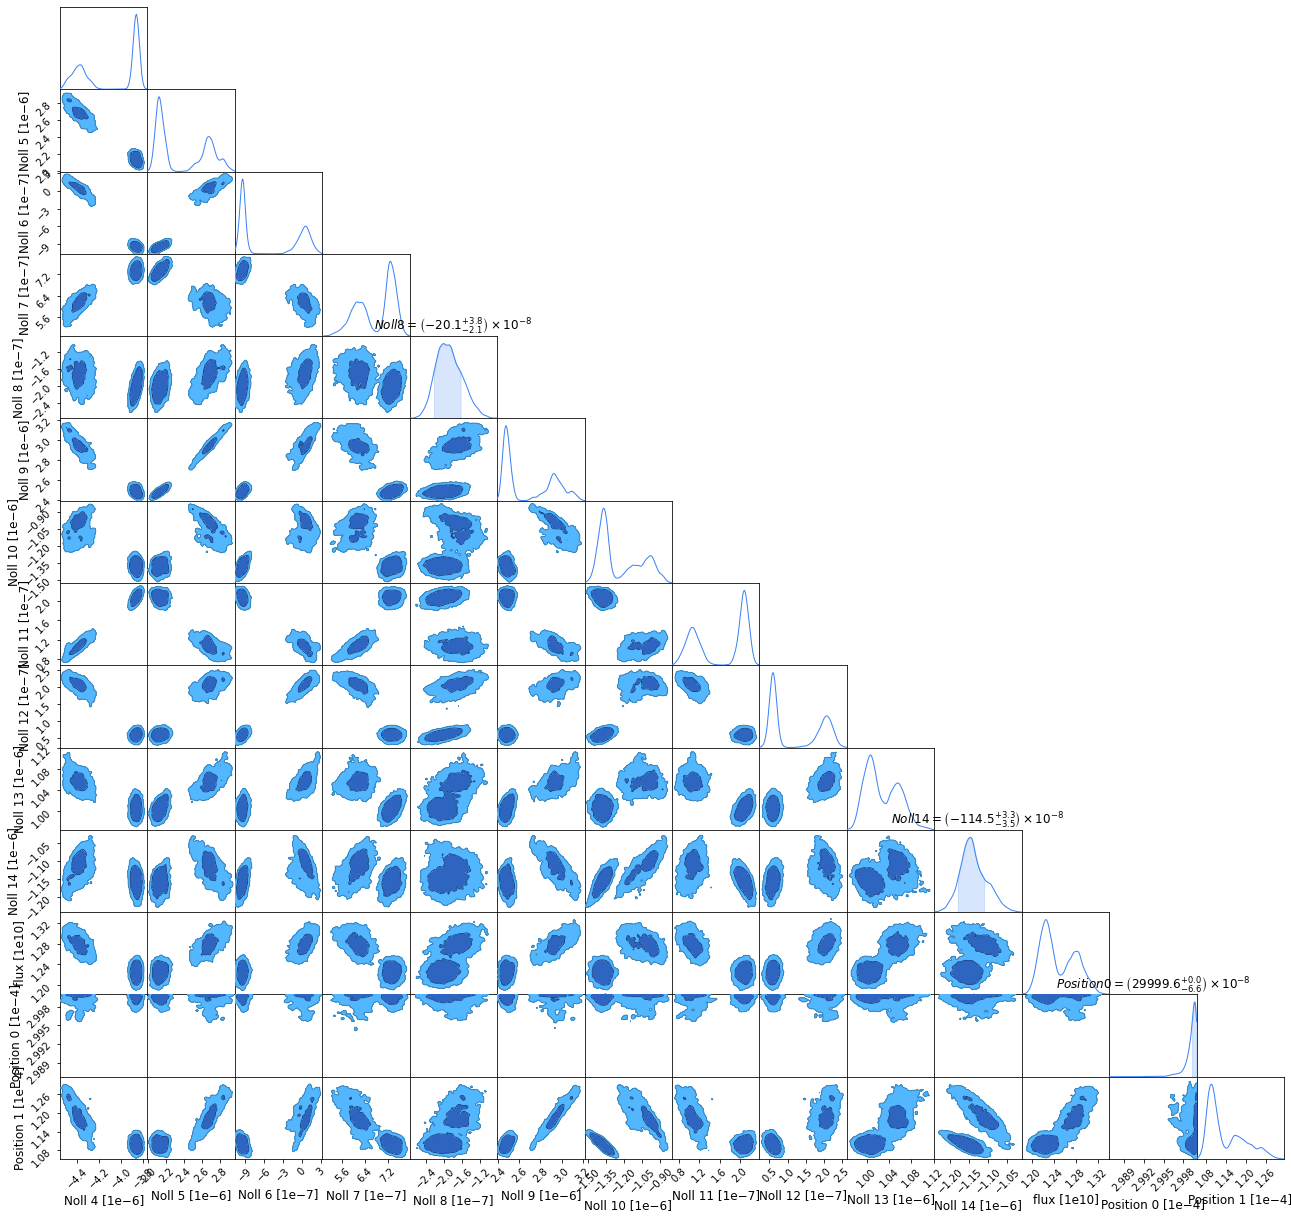

In [40]:
chain = cc.Chain(samples=pd.DataFrame.from_dict(new_samples), name="Parameter Inference")
consumer = cc.ChainConsumer().add_chain(chain)

fig = consumer.plotter.plot()
fig.set_size_inches((20,20))

________________________________________________________________________________________________________________________________________________

#### Compare to AOS data

In [ ]:
AOS_data_fname = data_dir+"zygo_data/20241115_142mmwindowinTB_PHASE_waves.npy"
phase_screen = np.load(AOS_data_fname)

center = [int(phase_screen.shape[0]/2)+40, int(phase_screen.shape[1]/2)+10]
radius = 520 #(px)

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.imshow(phase_screen)
plt.title("AOS Zygo Phase Data")
plt.colorbar(label="Phase (waves)")
plt.subplot(1,3,2)
cropped_phase_screen = phase_screen[center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius]
plt.imshow(cropped_phase_screen)
plt.title("Cropped")
plt.colorbar(label="Phase (waves)")
plt.subplot(1,3,3)
circ = dlu.circle(coords=coords, radius=aperture_diameter/2)
resized_masked_phase_screen = resize(cropped_phase_screen, (aperture_npix, aperture_npix))*circ
# resized_masked_phase_screen = dlu.rotate(resized_masked_phase_screen, angle=25*np.pi/180)
plt.imshow(resized_masked_phase_screen)
plt.title("Re-sized + Masked")
plt.colorbar(label="Phase (waves)")

In [ ]:
aos_model = optics_sp180.set("psf_npixels",1000)
test_wl = -6.328e-7 # AOS wl (m) used to measure phase (phase to OPD conversion)
aos_model = aos_model.insert_layer(layer=("ZygoPhaseScreen", dl.BasisLayer(basis=jnp.array([resized_masked_phase_screen*test_wl]),\
                                                                               coefficients=jnp.array([1]), as_phase=False)),index=1)
print(aos_model, aos_model.aperture.coefficients)
aos_psf = aos_model.propagate_mono(wavelength=green_laser_wl)

# load final, optimised, model (using green, spider 180 - best residuals)
final_model = optics_sp180.set("aperture.coefficients", green_glued_coeffs)
final_model = final_model.set("spider.rotation", final_spider_angle[0])
final_model = dl.Telescope(final_model, ('source', green_src))
final_model = final_model.set("source.position", np.asarray([final_pos[0]]))
print(final_model)


In [ ]:
# Compare phase screens (using red, spider 180)
%matplotlib inline
retrieved_basis_eval = np.tensordot(final_model.aperture.basis, final_model.aperture.coefficients, \
                                    axes=2 * (tuple(range(final_model.aperture.coefficients.ndim)),))

green_sp180_data = imgs[0][0,:,:]
psf_center_idx = np.unravel_index(np.argmax(green_sp180_data, axis=None), green_sp180_data.shape)
green_sp180_data = green_sp180_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                    psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]
mask = np.ones(green_sp180_data.shape)
mask[green_sp180_data <= 255] = 0

datapsfNorm = PowerNorm(gamma=0.2, vmin=green_sp180_data.min(), vmax=green_sp180_data.max())

plt.figure(figsize=(25,12))
plt.subplot(2,3,1)
plt.imshow(green_sp180_data, norm=datapsfNorm)
plt.colorbar()
plt.title("Measured Data")
plt.subplot(2,3,2)
model_psf = final_model.model()
psfNorm = PowerNorm(gamma=0.2, vmin=model_psf.min(), vmax=model_psf.max())
plt.imshow(model_psf*mask, norm=psfNorm) 
plt.title("Retrieved Image")
plt.colorbar()
# plt.xticks([])
# plt.yticks([])
plt.subplot(2,3,3)
plt.imshow(retrieved_basis_eval)
plt.title("Retrieved Basis")
plt.colorbar(label="OPD (m)")
# plt.xticks([])
# plt.yticks([])
plt.subplot(2,3,4)
plt.imshow(green_sp180_data, norm=datapsfNorm)
plt.colorbar()

plt.subplot(2,3,5)
psf_center_idx = np.unravel_index(np.argmax(aos_psf, axis=None), aos_psf.shape)
aos_psf_cropped = aos_psf[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                    psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]
psfNorm = PowerNorm(gamma=0.2, vmin=aos_psf.min(), vmax=aos_psf.max())
plt.imshow(aos_psf_cropped*mask, norm=psfNorm)
plt.title("Model Image - w AOS phase")
# plt.xticks([])
# plt.yticks([])
plt.colorbar()

plt.subplot(2,3,6)
# plt.xticks([])
# plt.yticks([])
plt.imshow(aos_model.ZygoPhaseScreen.eval_basis())
plt.title("AOS Measured Phase")
plt.colorbar(label="OPD (m)")